In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats
import h5py
import statistics
import math
from scipy.optimize import curve_fit
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (12,7.5)
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## Lab 4: Working with 'real' data
### Introduction
In this lab we are going to work on how to estimate the background from 'real' data. Real is in air quotes because the data is actually from simplified simulations to make the problems manageable in a single lab. But the data will have some features that resemble that of real data sets.

### Getting data and HD5
In general exchanging raw data is a pain. Writing data in text files is error prone, inaccurate, and wastes space, but raw binary files have all sorts of subtleties too (including the internal byte order of your processor). To try and sidestep a whole set of nasty issues, we are going to use HDF5 (originally developed by the National Center for Supercomputing Applications for data exchange) to allow everyone to import the data.

In [86]:
# import for Problem 1:
hf = h5py.File('gammaray_lab4.h5', 'r')
print(hf.keys())
data = np.array(hf.get('data'))
hf.close()
print(data)
print("First row: ")
print(data[0, :])

<KeysViewHDF5 ['data']>
[[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
  9.43272016e+08 9.43272016e+08]
 [3.15000000e+02 3.15007112e+02 3.15014225e+02 ... 3.45319109e+02
  3.45326221e+02 3.45333333e+02]
 [4.50000000e+01 4.50066667e+01 4.50133333e+01 ... 4.49866667e+01
  4.49933333e+01 4.50000000e+01]
 [1.00000000e+01 8.00000000e+00 7.00000000e+00 ... 8.00000000e+00
  1.10000000e+01 1.20000000e+01]]
First row: 
[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
 9.43272016e+08 9.43272016e+08]


### Problem 1
In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

As with most data, there are 'features.' Your lab instructor has helpfully incorporated the meta-data into your data file.

#### 1) Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().
Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 rows and more than 25 million columns. The rows are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. 

In [68]:
# parse data into separate lists
time = data[0, :]
solar_phase = data[1, :]
earth_deg = data[2, :]
part_counts = data[3, :]

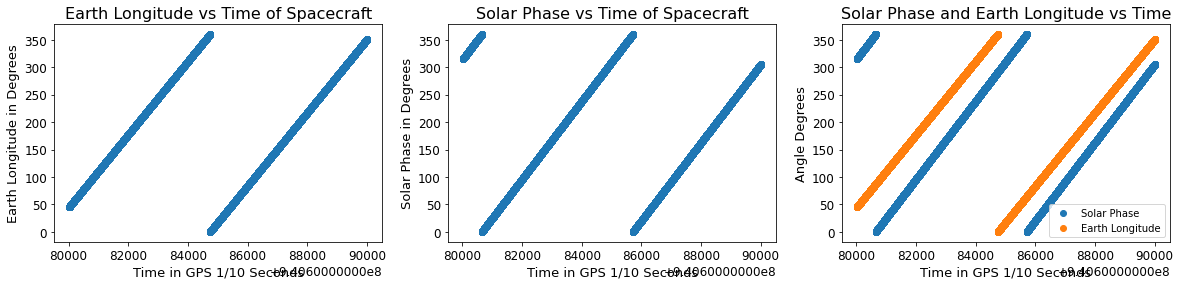

In [69]:
# plot various data to see data features
fig, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].scatter(time[:int(1e5)], earth_deg[:int(1e5)])
ax[0].set_title("Earth Longitude vs Time of Spacecraft", fontsize=16)
ax[0].set_xlabel("Time in GPS 1/10 Seconds", fontsize=13)
ax[0].set_ylabel("Earth Longitude in Degrees", fontsize=13)

ax[1].scatter(time[:int(1e5)], solar_phase[:int(1e5)])
ax[1].set_title("Solar Phase vs Time of Spacecraft", fontsize=16)
ax[1].set_xlabel("Time in GPS 1/10 Seconds", fontsize=13)
ax[1].set_ylabel("Solar Phase in Degrees", fontsize=13)

ax[2].scatter(time[:int(1e5)], solar_phase[:int(1e5)], label="Solar Phase")
ax[2].scatter(time[:int(1e5)], earth_deg[:int(1e5)], label="Earth Longitude")
ax[2].set_title("Solar Phase and Earth Longitude vs Time", fontsize=16)
ax[2].set_xlabel("Time in GPS 1/10 Seconds", fontsize=13)
ax[2].set_ylabel("Angle Degrees", fontsize=13)
ax[2].legend()

Text(0, 0.5, 'Cosmic Ray Counts')

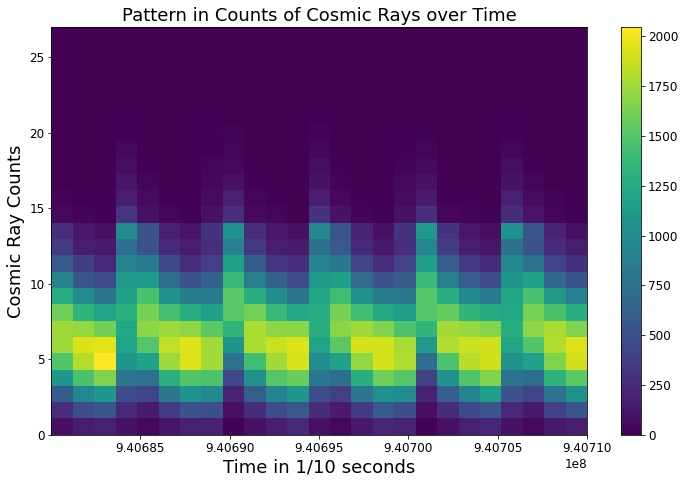

In [70]:
plt.hist2d(time[:300000], part_counts[:300000], bins=25)
plt.colorbar()
plt.title("Pattern in Counts of Cosmic Rays over Time", fontsize=18)
plt.xlabel("Time in 1/10 seconds", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

Text(0, 0.5, 'Cosmic Ray Counts')

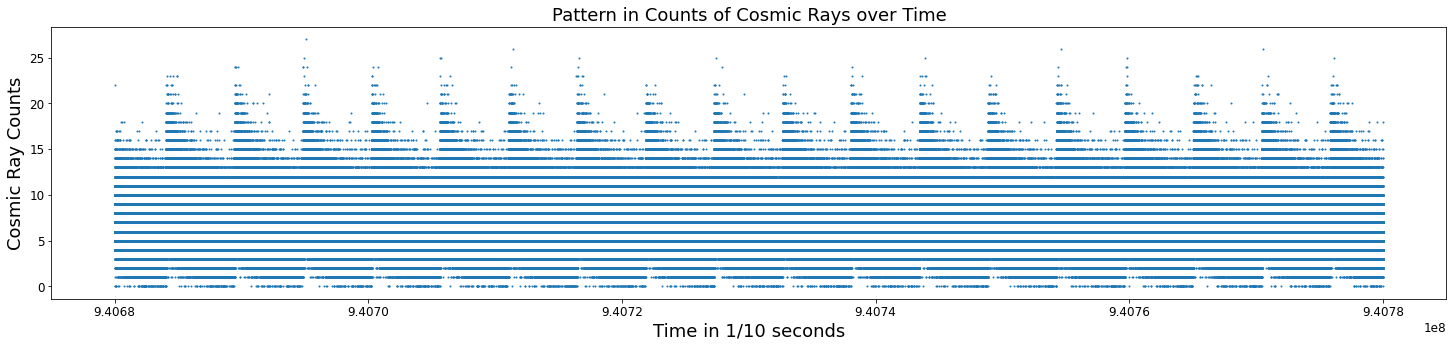

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.scatter(time[:int(1e6)], part_counts[:int(1e6)], s=1)
plt.title("Pattern in Counts of Cosmic Rays over Time", fontsize=18)
plt.xlabel("Time in 1/10 seconds", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

#### 1)
As we can see from the graphs of Earth Longitude vs. Time, the spacecraft does make a full revolution around the Earth approximately every 90 minutes. Also, the solar phase and earth longitude don't appear to be have the same period since they're offset by an non-constant amount. From the above graphs of Cosmic Rays vs. Time, we can see that the number of cosmic rays fluctuates based on the time in the cycle. The non-constant background can contaminate any signal that we see. We can build a background pdf by folding the data to one cycle, and then finding the distribution of the data at different points in time in the cycle.

#### 2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes
.

Text(0, 0.5, 'Cosmic Ray Counts')

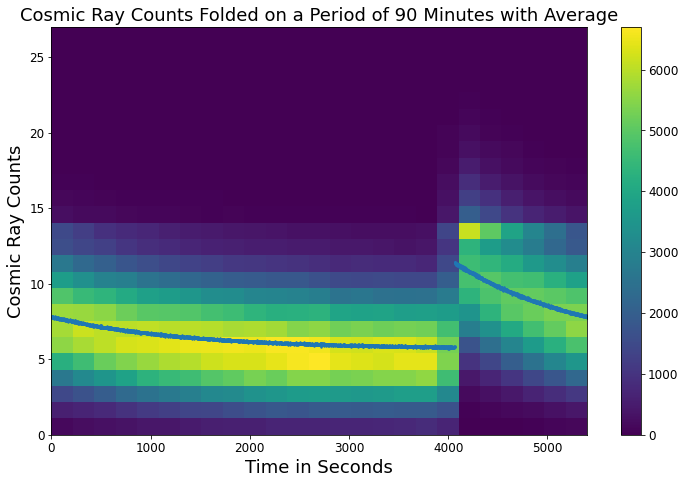

In [72]:
# fold time to 90 minute cycle (5400 seconds)
t_cycle = time % 5400
plt.hist2d(t_cycle[:int(1e6)], part_counts[:int(1e6)], bins=25)
plt.colorbar()
binned_stat = stats.binned_statistic(x=t_cycle, values=part_counts, statistic="mean", bins=5400)
plt.scatter(range(0,5400), binned_stat.statistic, s=2)
plt.title("Cosmic Ray Counts Folded on a Period of 90 Minutes with Average", fontsize=18)
plt.xlabel("Time in Seconds", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

Text(0, 0.5, 'Cosmic Ray Counts')

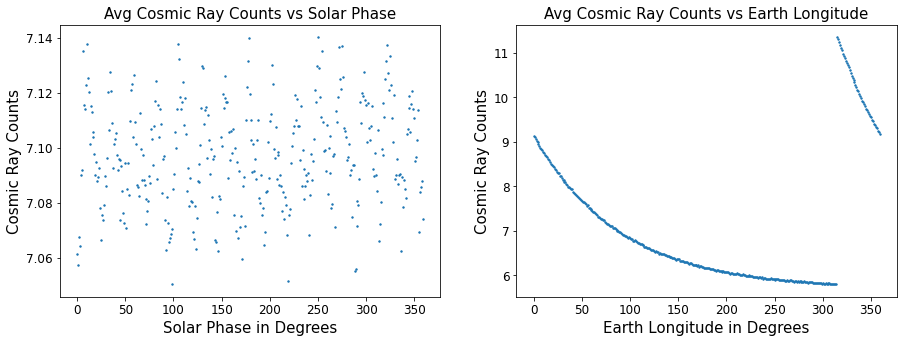

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

binned_stat = stats.binned_statistic(x=solar_phase, values=part_counts, statistic="mean", bins=360)
ax[0].scatter(range(0,360), binned_stat.statistic, s=2)
ax[0].set_title("Avg Cosmic Ray Counts vs Solar Phase", fontsize=15)
ax[0].set_xlabel("Solar Phase in Degrees", fontsize=15)
ax[0].set_ylabel("Cosmic Ray Counts", fontsize=15)

binned_stat = stats.binned_statistic(x=earth_deg, values=part_counts, statistic="mean", bins=360)
ax[1].scatter(range(0,360), binned_stat.statistic, s=2)
ax[1].set_title("Avg Cosmic Ray Counts vs Earth Longitude", fontsize=15)
ax[1].set_xlabel("Earth Longitude in Degrees", fontsize=15)
ax[1].set_ylabel("Cosmic Ray Counts", fontsize=15)

Text(0, 0.5, 'Cosmic Ray Counts')

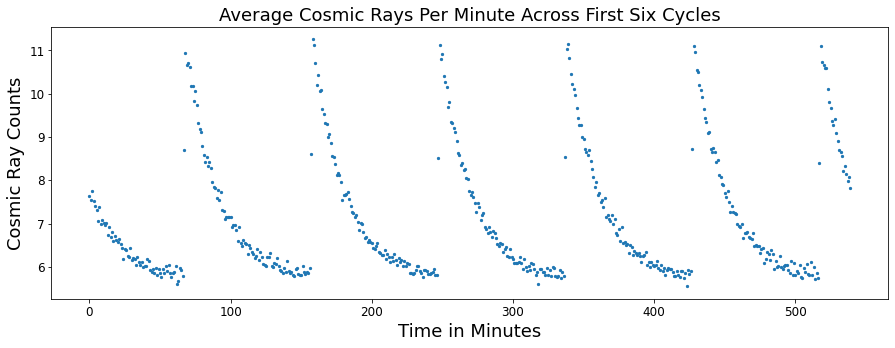

In [74]:
# first 6 cycles of data, each cycle is 54000 points
fig, ax = plt.subplots(1, 1, figsize=(15,5))
n = 54000*6
bins_6 = 90*6
binned_stat = stats.binned_statistic(x=time[:n], values=part_counts[:n], statistic="mean", bins=bins_6)
plt.scatter(range(0,bins_6), binned_stat.statistic, s=5)
plt.title("Average Cosmic Rays Per Minute Across First Six Cycles", fontsize=18)
plt.xlabel("Time in Minutes", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

#### 2)
The cosmic ray counts do not depend on the solar phase, but do vary with the longitude of the Earth. It seems as if the cycle for counts starts at around 320 degrees longitude, jumping at that longitudinal value, then exponentially decreasing until the start of the next cycle. As we can see from plotting the first 6 orbits worth of data, the number of cosmic rays per minutes jumps at the beginning of every cycle, then fall exponentially.

#### 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?


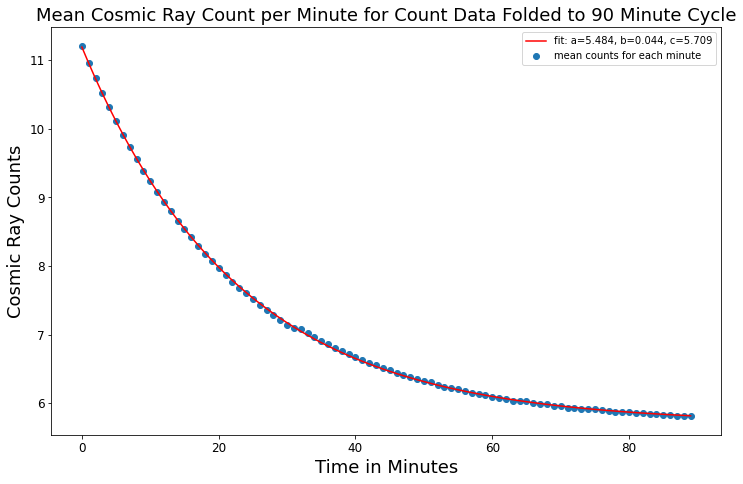

In [75]:
# bin all data per minute after folding time to 90 minute cycle
binned_stat = stats.binned_statistic(x=t_cycle, values=part_counts, statistic="mean", bins=90)
means = binned_stat.statistic
# sort by descending since data doesn't start at beginning of cycle for distribution
sorted_means_desc = np.sort(means)[::-1]
xdata = range(0, 90)

fig, ax = plt.subplots(1, 1)
ax.scatter(xdata, sorted_means_desc, label="mean counts for each minute")
plt.title("Mean Cosmic Ray Count per Minute for Count Data Folded to 90 Minute Cycle", fontsize=18)
plt.xlabel("Time in Minutes", fontsize=18)
plt.ylabel("Cosmic Ray Counts", fontsize=18)

# code borrowed from the scipy.optimize.curve_fit documentation
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, xdata, sorted_means_desc)
ax.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
ax.legend()

#### 3)

In each 90 minute cycle, the counts start high and decreases exponentially. We find this by folding the data to the 90 minute cycle and the taking the mean of all the data within each minute of the folded data, then plotting and curve-fitting these means. On average, the background data follows the function:  
Counts = 5.484 * e^(0.044x) + 5.709  
over each 90 minute cycle, where x is in minutes.

Mean Count for Minute 1 in the Cycle= 11.14646875
Mean Count for Minute 41 in the Cycle= 6.620751565762004
Mean Count for Minute 89 in the Cycle= 5.8065309672929715



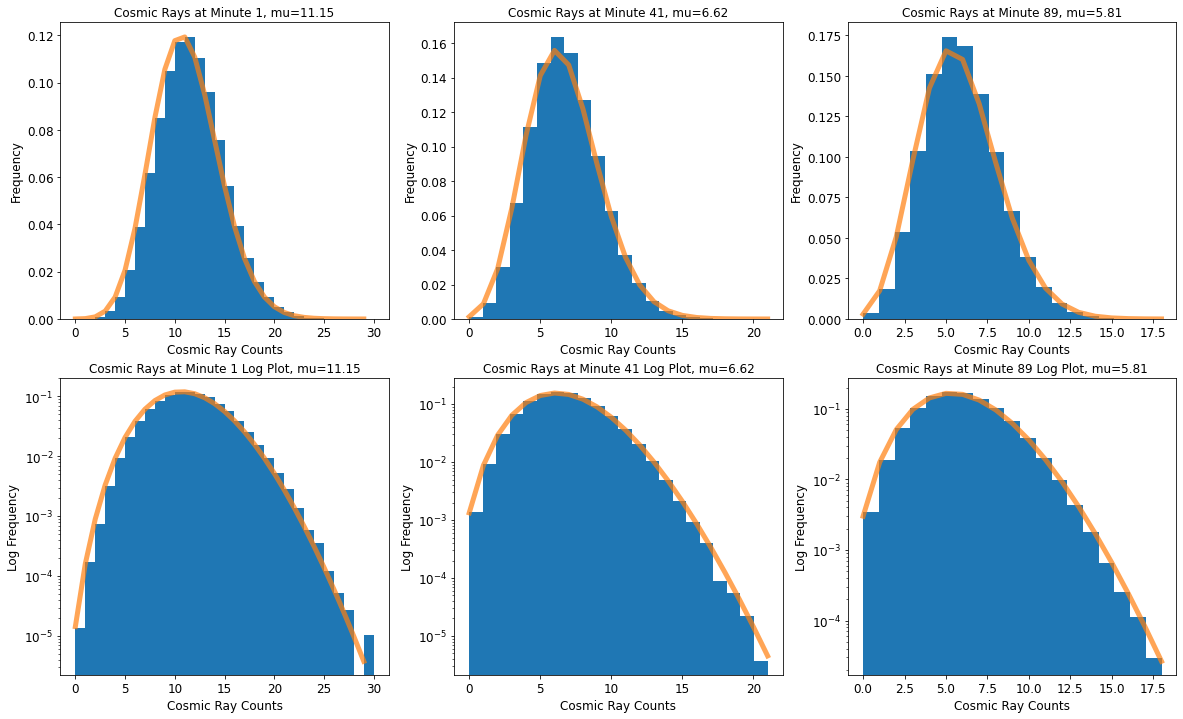

In [85]:
# from plotting the above graph without sorting, we find that the cycle starts at the 68th minute out of 90
# cut off <1 cycle in front so data starts at beginning of time cycle
i = 40800
time_cycle = t_cycle[i:]
# adjust count data accordingly
counts_new = part_counts[i:]

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

# plots distribution of cosmic rays at a certain minute in the 90 minute cycle - data folded to 90 minutes
# minute: the minute out of 90
# time_data: folded time data
# count_data: cosmic ray count data
# num_bins: number of bins used to display the count data
# plot_row: row in the subplot grid
# plot_col: col in the subplot grid
# yscale_log: plots data for this minute on a log plot if yscale_log='log'
# returns: mean: the mean for that minute of data
def plot_minute_dist(minute, time_data, count_data, num_bins, plot_row, plot_col, yscale_log):
    minute_data = []
    for i in range((minute-1)*600, len(time_data), 54000):
        minute_data.extend(count_data[i:i+600])
    ax[plot_row, plot_col].hist(minute_data, bins=num_bins, density=True)
    mean = statistics.mean(minute_data)
    x = np.arange(0, num_bins)
    ax[plot_row, plot_col].plot(x, stats.poisson.pmf(x, mean), linewidth = 5, alpha = 0.7)
    ax[plot_row, plot_col].set_xlabel('Cosmic Ray Counts', fontsize=12)
    if yscale_log == 'log':
        print("Mean Count for Minute " + str(minute) + " in the Cycle= " + str(mean))
        ax[plot_row, plot_col].set_yscale('log')
        ax[plot_row, plot_col].set_title('Cosmic Rays at Minute ' + str(minute) + " Log Plot, mu=" + str(round(mean, 2)), fontsize=12)
        ax[plot_row, plot_col].set_ylabel('Log Frequency', fontsize=12)
    else:
        ax[plot_row, plot_col].set_title('Cosmic Rays at Minute ' + str(minute) + ", mu=" + str(round(mean, 2)), fontsize=12)
        ax[plot_row, plot_col].set_ylabel('Frequency', fontsize=12)
    return mean

mean_1 = plot_minute_dist(1, time_cycle, counts_new, 30, 0, 0, '')
mean_41 = plot_minute_dist(41, time_cycle, counts_new, 22, 0, 1, '')
mean_89 = plot_minute_dist(89, time_cycle, counts_new, 19, 0, 2, '')
plot_minute_dist(1, time_cycle, counts_new, 30, 1, 0, 'log')
plot_minute_dist(41, time_cycle, counts_new, 22, 1, 1, 'log')
plot_minute_dist(89, time_cycle, counts_new, 19, 1, 2, 'log')
print()

#### 3)
The cosmic ray counts for each minute in the 90 minute cycle roughly follows a Poisson distribution, with mu being the average number of cosmic ray counts for that minute. The log plots further show that the data for each minute roughly follows a Poisson distribution. As shown in the plot before this one, the means for these Poisson distributions follow a decreasing exponential curve, reflected in the magnitude of these means at different times (minute 1, 41, and 89 in this case).

#### 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [82]:
print("5-sigma threshold at minute 1: " + str(stats.poisson.ppf(stats.norm.cdf(5), mu=mean_1)))
print("5-sigma threshold at minute 41: " + str(stats.poisson.ppf(stats.norm.cdf(5), mu=mean_41)))
print("5-sigma threshold at minute 89: " + str(stats.poisson.ppf(stats.norm.cdf(5), mu=mean_89)))

5-sigma threshold at minute 1: 31.0
5-sigma threshold at minute 41: 23.0
5-sigma threshold at minute 89: 21.0


### Problem 2: Looking for a Transient
In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

#### 1) Download the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [3]:
# import for Problem 2:
hf = h5py.File('images.h5', 'r')
print(hf.keys())
image_1 = np.array(hf.get('image1'))
ims = np.array(hf.get('imagestack'))
hf.close()

<KeysViewHDF5 ['image1', 'imagestack']>


#### 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

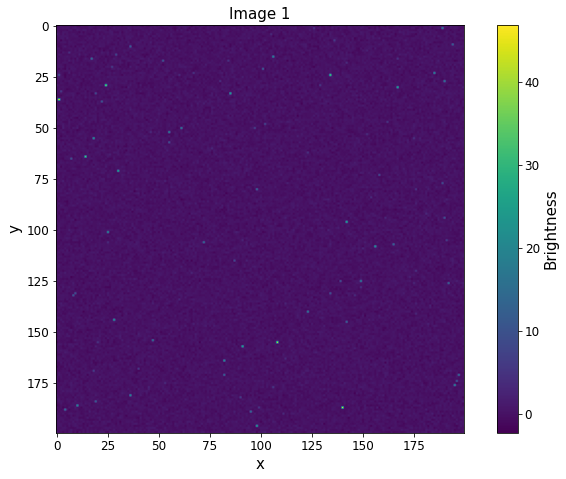

In [4]:
plt.title('Image 1', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.imshow(image_1)
cbar = plt.colorbar()
cbar.set_label('Brightness', fontsize=15)

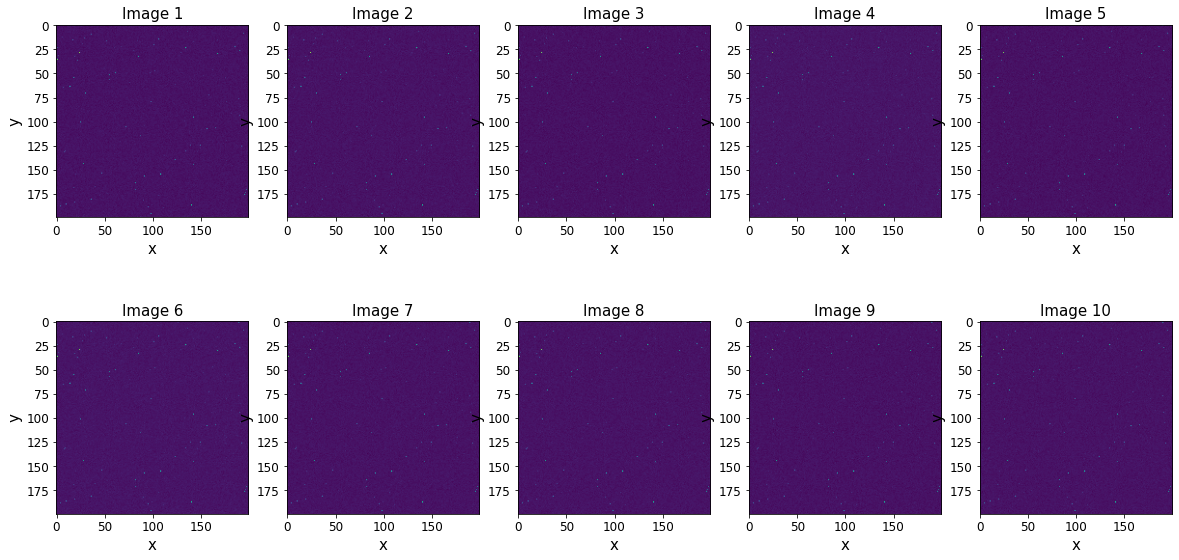

In [216]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

x = 0
for n in range(1, 11):
    y = n - 1
    if (n-1) > 4:
        x = 1
        y = (n-1) % 5
    ax[x][y].imshow(ims[:,:,n-1])
    ax[x][y].set_title('Image ' + str(n), fontsize=15)
    ax[x][y].set_xlabel('x', fontsize=15)
    ax[x][y].set_ylabel('y', fontsize=15)

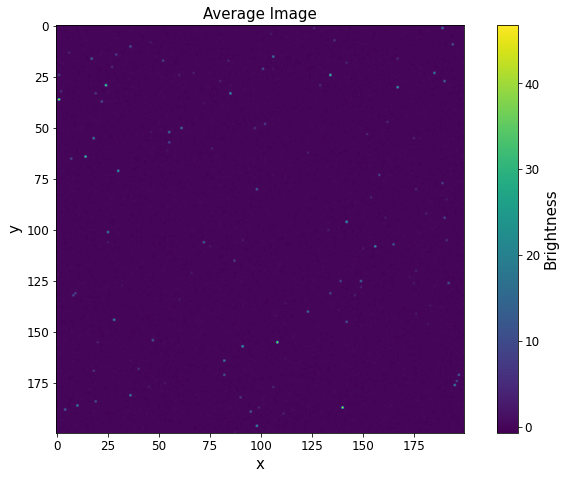

In [5]:
im_avg = np.mean(ims, axis=2)
plt.imshow(im_avg)
plt.title('Average Image', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
cbar = plt.colorbar()
cbar.set_label('Brightness', fontsize=15)

-2.960367924920029  2.9532008163968406
(0, array([], dtype=float64))
-2.958743845906104  2.9528818475985132
(1, array([], dtype=float64))
-2.9499543046040158  2.9601834416975668
(2, array([], dtype=float64))
-2.962312558782015  2.962641682788309
(3, array([], dtype=float64))
-2.9553085304449236  2.957467917855285
(4, array([], dtype=float64))
-2.9491842084568964  2.959626236201041
(5, array([], dtype=float64))
-2.9470099312172926  2.935630182888308
(6, array([], dtype=float64))
-2.9655697895120143  2.9620205178939267
(7, array([], dtype=float64))
-2.952534073783852  2.952092451570626
(8, array([], dtype=float64))
-2.9506013600377985  2.955841432598251
(9, array([], dtype=float64))


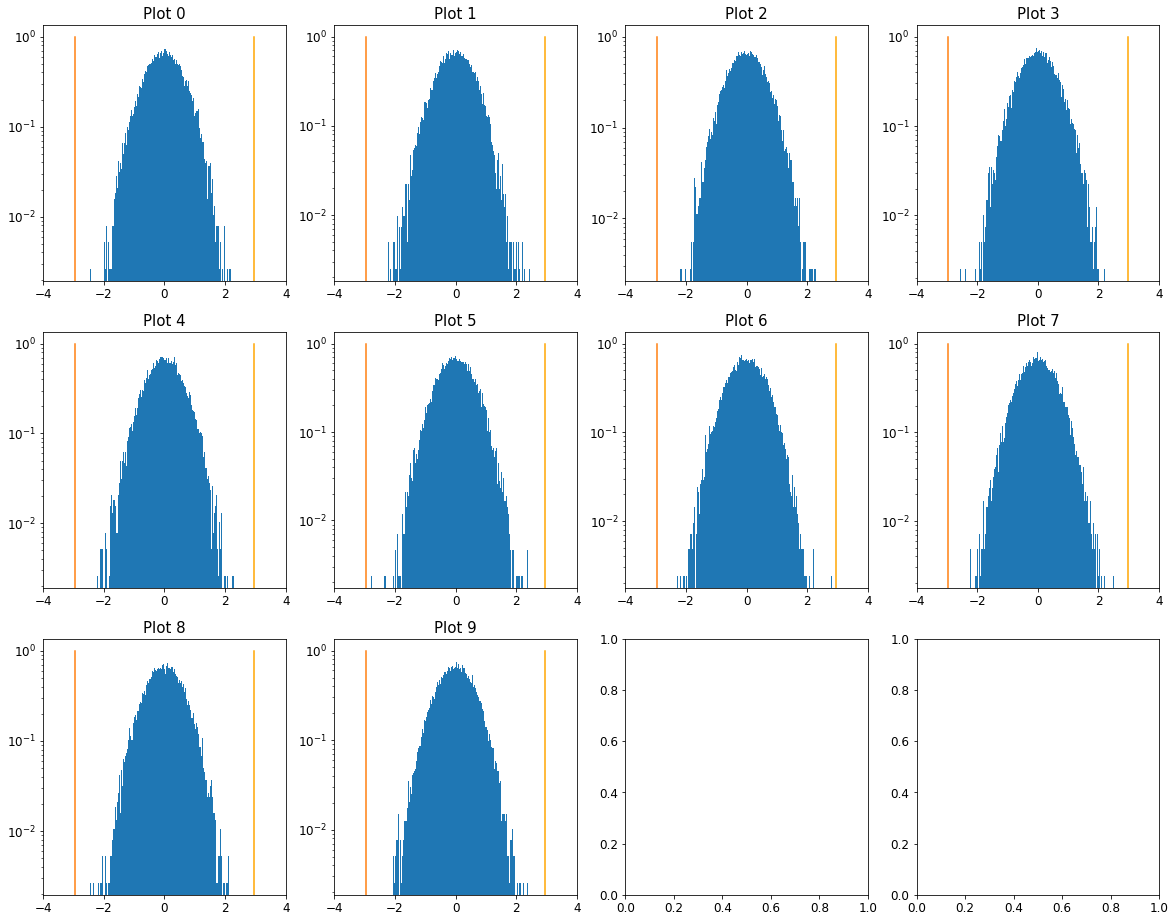

In [50]:
# instead of including all images into one average, choose one image to exclude at a time

fig, ax = plt.subplots(3, 4, figsize=(20, 16))

def transient_search(n, im, other_ims):
    img_avg = np.mean(other_ims, axis=2)
    trans = []
    for i in range(len(other_ims[0,0,:])):
        trans = im - img_avg
    trans = np.array(trans).flatten()
    mean = np.mean(trans)
    std_dev = np.std(trans)
    lower_lim = stats.norm.ppf(stats.norm.cdf(-5), loc=mean, scale=std_dev)
    upper_lim = stats.norm.ppf(stats.norm.cdf(5), loc=mean, scale=std_dev)
    print(str(lower_lim) + "  " + str(upper_lim))
    
    ax[int(n/4)][n%4].hist(trans, bins=500, density=True)
    ax[int(n/4)][n%4].set_yscale('log')
    ax[int(n/4)][n%4].set_xlim(-4,4)
    ax[int(n/4)][n%4].plot([lower_lim, lower_lim], [0, 1])
    ax[int(n/4)][n%4].plot([upper_lim, upper_lim], [0, 1], color='orange')
    ax[int(n/4)][n%4].set_title('Plot ' + str(n), fontsize=15)
    
    return (n, np.concatenate((trans[trans<lower_lim], trans[trans>upper_lim]), axis=0))

for i in range(10):
    print(transient_search(i, ims[:,:,i], np.concatenate((ims[:,:,:i], ims[:,:,i+1:]), axis=2)))




In [12]:
print(len(ims[0,0,:]))

10


Mean: -5.684341886080802e-19
Std Dev: 0.53193860359903


Text(0, 0.5, 'Frequency')

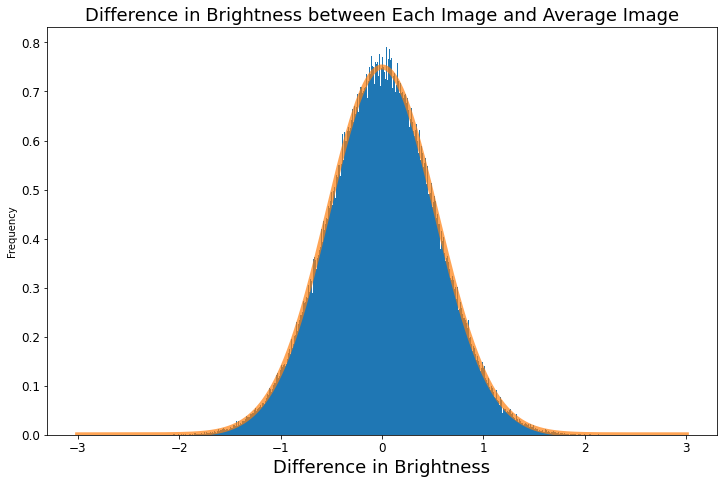

In [245]:
trans = []
for i in range(10):
    trans.append(ims[:,:,i] - im_avg)
trans = np.array(trans).flatten()
plt.hist(trans.flatten(), bins=1000, density=True)

mean = np.mean(trans)
std_dev = np.std(trans)
print("Mean: " + str(mean))
print("Std Dev: " + str(std_dev))
x = np.linspace(-3,3,1000)
plt.plot(x, stats.norm.pdf(x, mean, std_dev), linewidth = 5, alpha = 0.7)
plt.title("Difference in Brightness between Each Image and Average Image", fontsize=18)
plt.xlabel("Difference in Brightness", fontsize=18)
plt.ylabel("Frequency")

#### 2)
There is no signal contamination since there is no obvious skew to the data. The background is not time dependent. The data is not consistent spatially since there are spots of brightness that represent stars. To calculate the background pdf for searching for transients, we find the average image, then subtract it from each of the ten images to create a distribution of differences.

#### 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

In [246]:
lower_lim = stats.norm.ppf(stats.norm.cdf(-5), loc=mean, scale=std_dev)
upper_lim = stats.norm.ppf(stats.norm.cdf(5), loc=mean, scale=std_dev)
print("Lower Limit: " + str(lower_lim))
print("Upper Limit: " + str(upper_lim))
print(trans[trans<lower_lim])
print(trans[trans>upper_lim])

Lower Limit: -2.6596930179951506
Upper Limit: 2.6596930179792855
[]
[]


At 5-sigma level of detection, no transients were found, both below the lower threshold and above the upper threshold.

#### 4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.
In finding the faintest stars, my partner had to build a pdf of the brightness of the average image to find the threshold that distinguished the darker background from the faintest of stars. On the other hand, I had to build a pdf of the differences between the 10 images and the average image to see if anything stood out to look for transients. We had to build different background pdfs.